# Logistic Regression as a Neural Network 
(partly following deeplearning.ai lab)

    - Initializing parameters
    - Calculating the cost function and its gradient
    - Using an optimization algorithm (gradient descent) 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split

import scipy
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
df = pd.read_csv('bioresponse.csv')
X = df.iloc[:, 1:]
y = df.Activity.values

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75)

## General Architecture of the algorithm ##


Build a Logistic Regression, using a Neural Network mindset.

**Logistic Regression is actually a very simple Neural Network!**


**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})$$

Key steps:

  -Initialize the parameters of the model

  -Learn the parameters for the model by minimizing the cost  

  -Use the learned parameters to make predictions (on the test set)
  
  -Analyse the results and conclude

## Parts of our algorithm ## 

The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features, number of layers, number of neurons in the layer etc.) 
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

Build 1-3 separately and integrate them into one function we call `model()`.

### Sigmoid

$sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$ 

In [4]:
def sigmoid(z):

    s = 1./(1.+np.exp(-z))
    
    return s

### Initializing parameters



In [5]:
def initialize_with_zeros(dim):

    w = np.zeros((dim,1))
    b = 0.
    
    return w, b

### Forward and Backward propagation

Implement a function `propagate()` that computes the cost function and its gradient.

Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas we should use: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})$$

In [6]:
def propagate(w, b, X, Y):

    m = X.shape[1]

    A = sigmoid(np.dot(w.T,X)+b )                                 # compute activation
    cost = -(1./m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A),axis=1)   # compute cost

    dw = (1./m)*np.dot(X,(A-Y).T)
    db = (1./m)*np.sum(A-Y,axis=1)

    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

### Optimization
- We have initialized the parameters.
- We are able to compute a cost function and its gradient.
- Now, we have to update the parameters using gradient descent.

For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [7]:
def gd(w, b, X, Y, num_iterations, learning_rate, print_cost = False):

    costs = []
    
    for i in range(num_iterations):

        grads, cost = propagate(w,b,X,Y)

        dw = grads["dw"]
        db = grads["db"]

        w -=learning_rate*dw
        b -=learning_rate*db

        if i % 100 == 0:
            costs.append(cost)

        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [8]:
def sgd(w, b, X, Y, num_iterations, learning_rate, print_cost = False):

    costs = []

    for i in range(num_iterations):
        index = np.random.choice(X.shape[1], size=1, replace=False)[0]

        grads, cost = propagate(w,b,np.expand_dims(X[:,index],axis=1),Y[index])

        dw = grads["dw"]
        db = grads["db"]

        w -=learning_rate*dw
        b -=learning_rate*db

        if i % 100 == 0:
            costs.append(cost)

        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    params = {"w": w,
              "b": b}

    grads = {"dw": dw,
             "db": db}

    return params, grads, costs

In [9]:
def adam_optimization(w, b, X, Y, num_iterations, learn_rate, print_cost = False, momentum_decay=0.9, scaling_decay=0.999, e=1e-8):

    costs = []

    momentum_vector_w = np.random.random((X.shape[0], 1))
    momentum_vector_b = np.random.random()

    second_momentum_vector_w = np.random.random((X.shape[0], 1))
    second_momentum_vector_b = np.random.random()

    unbias_w = np.random.random((X.shape[0], 1))
    unbias_b = np.random.random()

    second_unbias_w = np.random.random((X.shape[0], 1))
    second_unbias_b = np.random.random()

    epoch = 0
    for i in range(num_iterations):
        epoch += 1

        grads, cost = propagate(w,b,X,Y)

        dw = grads["dw"]
        db = grads["db"]

        momentum_vector_w = momentum_decay * momentum_vector_w + (1 - momentum_decay)*dw
        second_momentum_vector_w = scaling_decay * second_momentum_vector_w + (1 - scaling_decay)*dw**2
        unbias_w = momentum_vector_w / (1 - momentum_decay**epoch)
        second_unbias_w = second_momentum_vector_w / (1 - scaling_decay**epoch)

        momentum_vector_b = momentum_decay * momentum_vector_b + (1 - momentum_decay)*db
        second_momentum_vector_b = scaling_decay * second_momentum_vector_b + (1 - scaling_decay)*db**2
        unbias_b = momentum_vector_b / (1 - momentum_decay**epoch)
        second_unbias_b = second_momentum_vector_b / (1 - scaling_decay**epoch)

        w -= learn_rate * np.divide(unbias_w, np.sqrt(second_unbias_w + e))
        b -= learn_rate * np.divide(unbias_b, np.sqrt(second_unbias_b + e))

        if i % 100 == 0:
            costs.append(cost)

        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    params = {"w": w,
              "b": b}

    grads = {"dw": dw,
             "db": db}

    return params, grads, costs

Implement the `predict()` function. There are two steps to compute predictions:

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

2. Convert the entries of A into 0 (if activation <= 0.5) or 1 (if activation > 0.5), store the predictions in a vector `Y_prediction`.

In [10]:
def predict(w, b, X):

    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)

    A = sigmoid(np.dot(w.T,X)+b)

    for i in range(A.shape[1]):

        if (A[0,i]<=0.5):
            Y_prediction[0][i]=0
        else:
            Y_prediction[0][i]=1

    return Y_prediction


Already have:
- Initialize (w,b)
- Optimize the loss iteratively to learn parameters (w,b):
    - computing the cost and its gradient
    - updating the parameters using gradient descent
- Use the learned (w,b) to predict the labels for a given set of examples

## Merge it all into a model ##

    - Y_prediction_test for the predictions on the test set
    - Y_prediction_train for the predictions on the train set
    - w, costs, grads for the outputs of optimize()

In [11]:
def model(X_train, Y_train, X_test, Y_test, optimization, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    # an argument 'optimization' was added in order to perform different optimization algorithms

    w, b = initialize_with_zeros(X_train.shape[0])

    parameters, grads, costs = optimization(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

    w = parameters["w"]
    b = parameters["b"]

    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    # print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    train_accuracy = 100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100
    test_accuracy = 100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100

    if optimization.__name__ == 'gd':
        name = 'Gradient Descent'
    elif optimization.__name__ == 'sgd':
        name = 'Stochastic Gradient Descent'
    else:
        name = 'Adam Optimization'


    print(name + " train accuracy: {} %".format(train_accuracy))
    print(name + " test accuracy: {} %".format(test_accuracy))

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train" : Y_prediction_train,
         "w" : w,
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations,
         "train_accuracy": train_accuracy,
         "test_accuracy": test_accuracy}

    return d

Run the following cell to train your model.

In [12]:
gd_model = model(X_train.to_numpy().T, y_train, X_test.to_numpy().T, y_test, optimization=gd, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 1.090997
Cost after iteration 200: 0.872662
Cost after iteration 300: 0.792862
Cost after iteration 400: 0.740021
Cost after iteration 500: 0.603200
Cost after iteration 600: 0.833746
Cost after iteration 700: 0.515184
Cost after iteration 800: 0.901332
Cost after iteration 900: 0.494019
Cost after iteration 1000: 0.689769
Cost after iteration 1100: 0.564756
Cost after iteration 1200: 0.466614
Cost after iteration 1300: 0.806189
Cost after iteration 1400: 0.503947
Cost after iteration 1500: 0.439731
Cost after iteration 1600: 0.594907
Cost after iteration 1700: 0.718761
Cost after iteration 1800: 0.518959
Cost after iteration 1900: 0.430121
Gradient Descent train accuracy: 83.46960540348383 %
Gradient Descent test accuracy: 76.65245202558636 %


Bibliography:
- http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/


In [13]:
sgd_model = model(X_train.to_numpy().T, y_train, X_test.to_numpy().T, y_test, optimization=sgd, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 19.018099
Cost after iteration 200: nan
Cost after iteration 300: nan
Cost after iteration 400: 7.927132
Cost after iteration 500: nan
Cost after iteration 600: 0.000000
Cost after iteration 700: 28.908763
Cost after iteration 800: 26.868413
Cost after iteration 900: 0.000051
Cost after iteration 1000: nan
Cost after iteration 1100: 0.000000
Cost after iteration 1200: nan
Cost after iteration 1300: 0.000007
Cost after iteration 1400: nan
Cost after iteration 1500: 0.000057
Cost after iteration 1600: 0.239409
Cost after iteration 1700: 13.317122
Cost after iteration 1800: 2.640020
Cost after iteration 1900: nan
Stochastic Gradient Descent train accuracy: 73.23142552435124 %
Stochastic Gradient Descent test accuracy: 71.96162046908316 %


In [14]:
adam_model = model(X_train.to_numpy().T, y_train, X_test.to_numpy().T, y_test, optimization=adam_optimization, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 4.845681
Cost after iteration 200: 1.503088
Cost after iteration 300: 0.933957
Cost after iteration 400: 0.697388
Cost after iteration 500: 0.570493
Cost after iteration 600: 0.497231
Cost after iteration 700: 0.453730
Cost after iteration 800: 0.422750
Cost after iteration 900: 0.399134
Cost after iteration 1000: 0.380440
Cost after iteration 1100: 0.365071
Cost after iteration 1200: 0.352071
Cost after iteration 1300: 0.341074
Cost after iteration 1400: 0.332131
Cost after iteration 1500: 0.324459
Cost after iteration 1600: 0.317610
Cost after iteration 1700: 0.311381
Cost after iteration 1800: 0.305647
Cost after iteration 1900: 0.300325
Adam Optimization train accuracy: 87.34447209384999 %
Adam Optimization test accuracy: 77.71855010660981 %


In [15]:
accuracy = pd.DataFrame({'': ['Train accuracy GD', 'Test accuracy GD', 'Train accuracy SGD','Test accuracy SGD', 'Train accuracy Adam','Test accuracy Adam']})

def get_plot(l_rate):
    print('Learning_rate =', l_rate)

    gd_lr_test = model(X_train.to_numpy().T, y_train, X_test.to_numpy().T, y_test, optimization=gd, learning_rate=l_rate, print_cost=False)

    sgd_lr_test = model(X_train.to_numpy().T, y_train, X_test.to_numpy().T, y_test, optimization=sgd, learning_rate=l_rate, print_cost=False)

    adam_lr_test = model(X_train.to_numpy().T, y_train, X_test.to_numpy().T, y_test, optimization=adam_optimization, learning_rate=l_rate, print_cost=False)

    accuracy[l_rate] = [gd_lr_test["train_accuracy"], gd_lr_test["test_accuracy"], sgd_lr_test["train_accuracy"], sgd_lr_test["test_accuracy"], adam_lr_test["train_accuracy"], adam_lr_test["test_accuracy"]]
    iterations = range(0, gd_lr_test["num_iterations"], 100)

    plt.plot(iterations, gd_lr_test["costs"], 'r', label = 'Gradient Descent')
    plt.plot(iterations, sgd_lr_test["costs"], 'b', label = 'Stochastic Gradient Descent')
    plt.plot(iterations, adam_lr_test["costs"], 'g', label = 'Adam Optimization')

    plt.xlabel("N of iterations",fontsize = 10)
    plt.ylabel("Loss function",fontsize = 10)

    plt.title(f'Learning rate: {l_rate}')
    plt.legend(fontsize = 10)

Learning_rate = 6e-06
Gradient Descent train accuracy: 54.568076786349096 %
Gradient Descent test accuracy: 53.19829424307036 %
Stochastic Gradient Descent train accuracy: 54.568076786349096 %
Stochastic Gradient Descent test accuracy: 53.19829424307036 %
Adam Optimization train accuracy: 54.568076786349096 %
Adam Optimization test accuracy: 53.19829424307036 %
Learning_rate = 5e-05
Gradient Descent train accuracy: 54.568076786349096 %
Gradient Descent test accuracy: 53.19829424307036 %
Stochastic Gradient Descent train accuracy: 54.568076786349096 %
Stochastic Gradient Descent test accuracy: 53.19829424307036 %
Adam Optimization train accuracy: 57.90970494134376 %
Adam Optimization test accuracy: 56.82302771855011 %
Learning_rate = 0.0004
Gradient Descent train accuracy: 65.73053679345894 %
Gradient Descent test accuracy: 64.49893390191897 %
Stochastic Gradient Descent train accuracy: 64.23746889441877 %
Stochastic Gradient Descent test accuracy: 61.62046908315565 %
Adam Optimization 

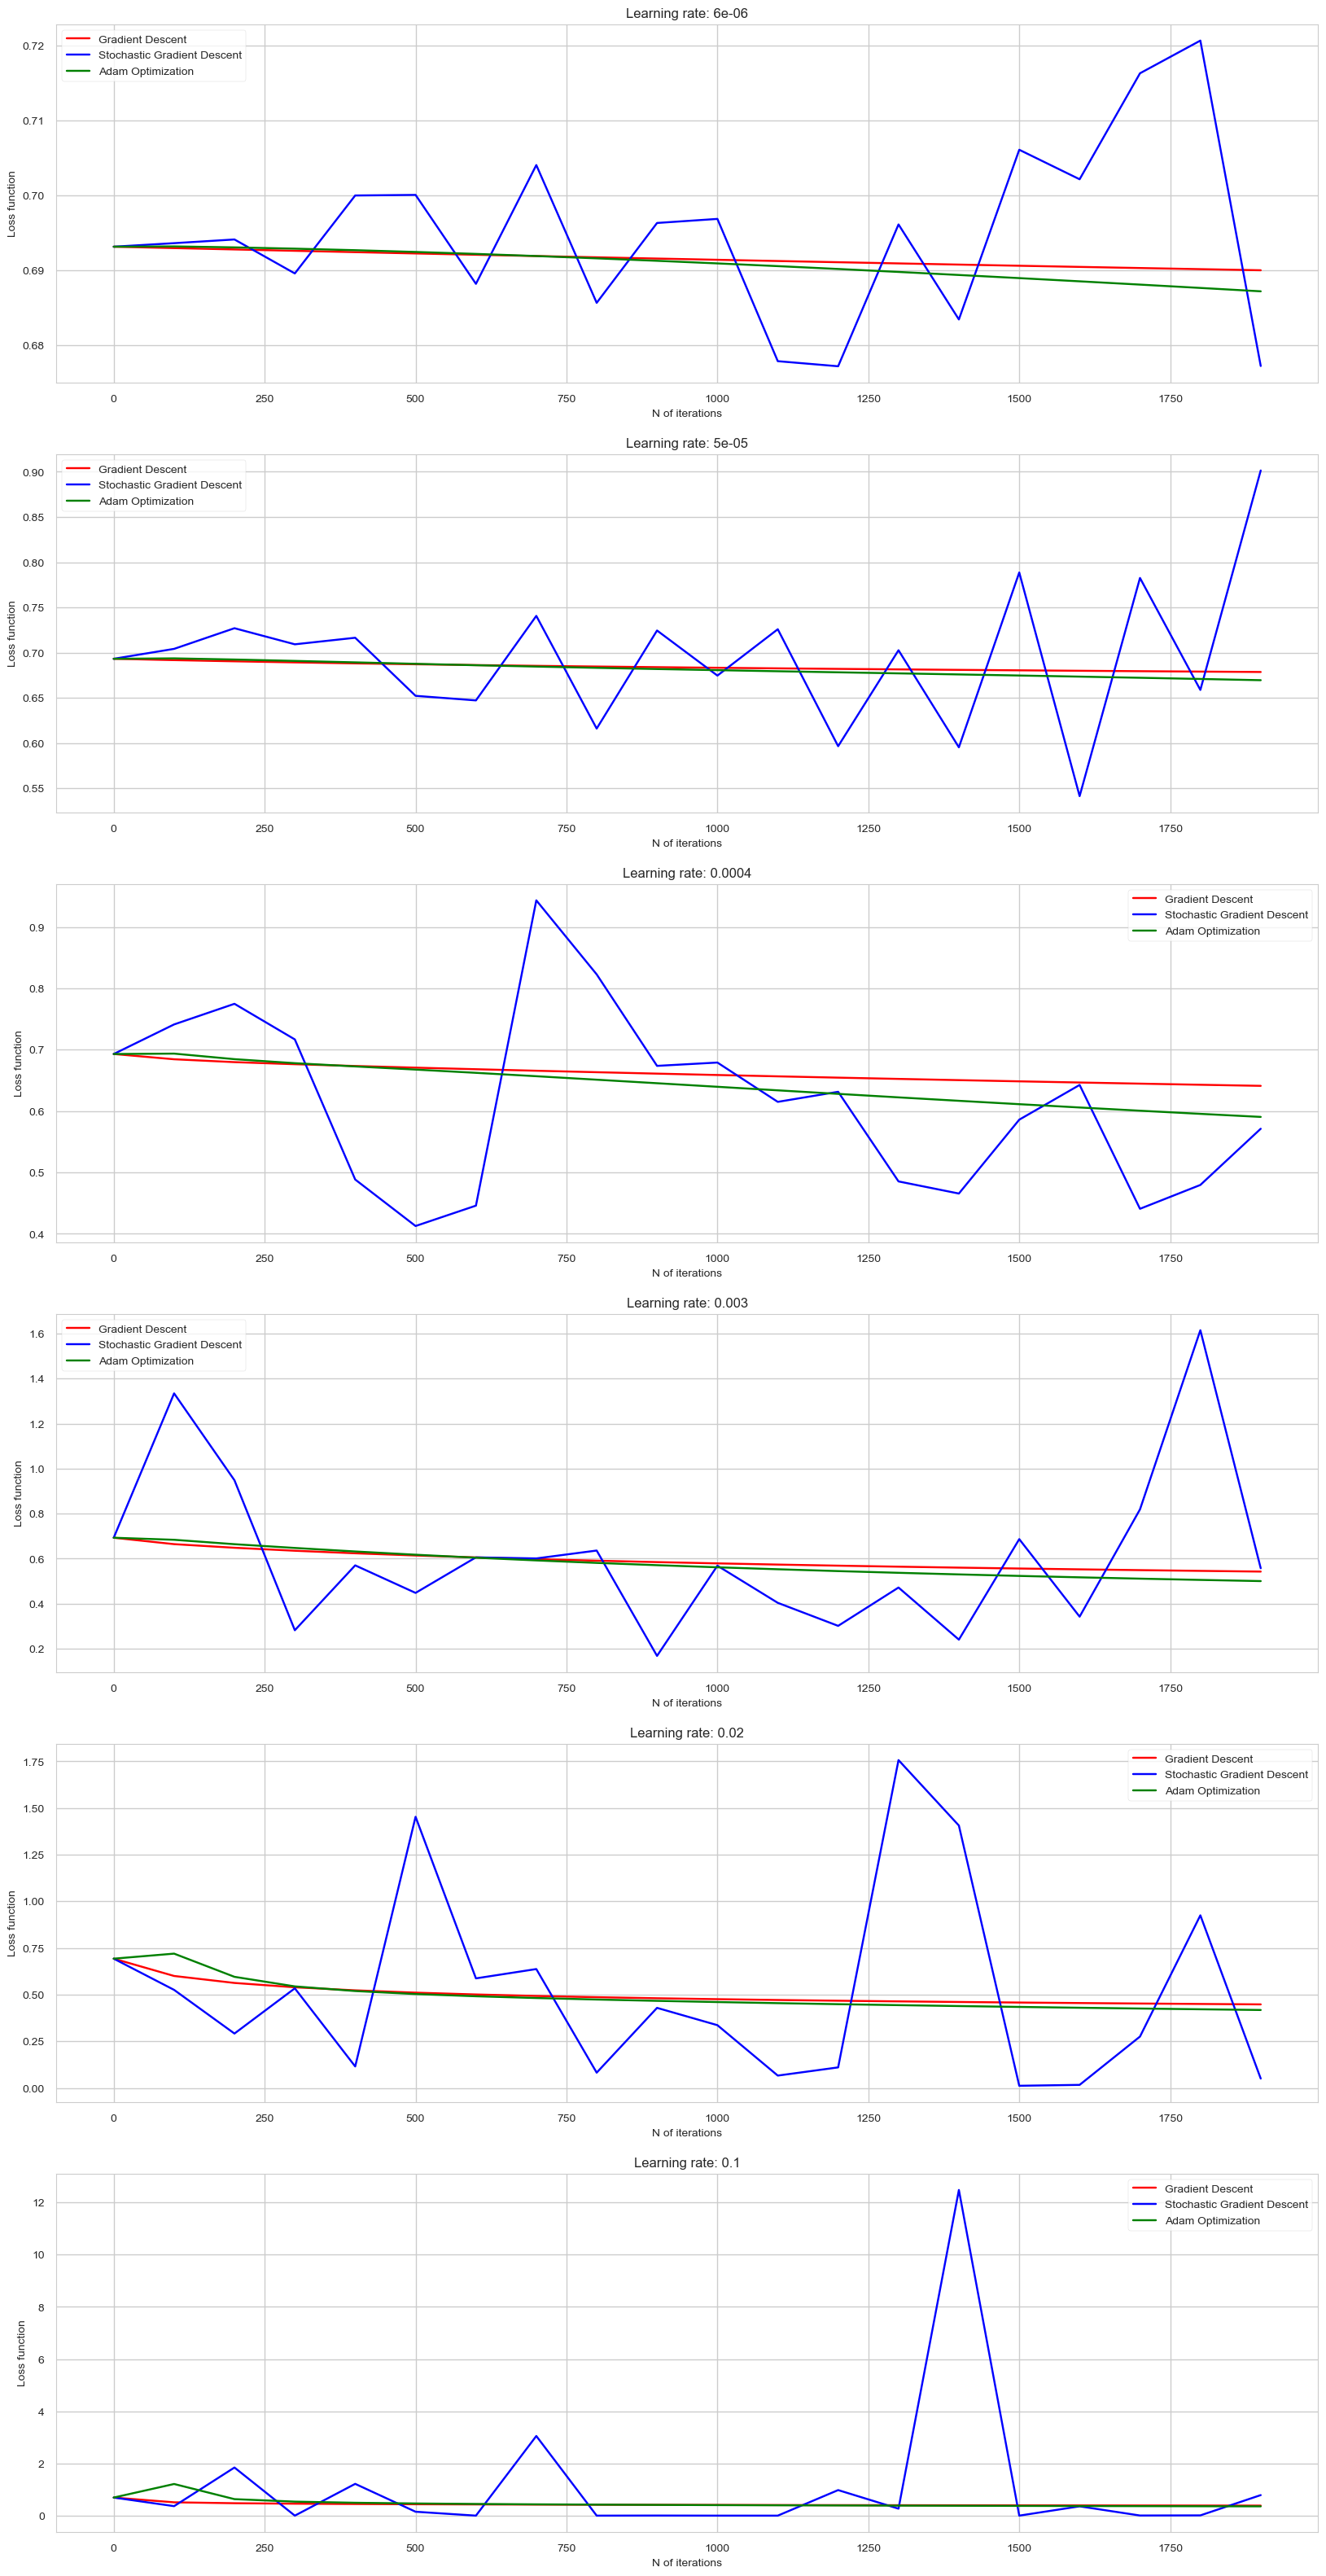

In [16]:
plt.figure(figsize=(20, 40))
plt.style.use('seaborn-notebook')

rate = [6e-6, 5e-5, 4e-4, 3e-3, 2e-2, 1e-1]
for i in range(len(rate)):
    plt.subplot(6, 1, i+1)
    get_plot(rate[i])

In [17]:
accuracy

,,6e-06,5e-05,0.0004,0.003,0.02,0.1
0,Train accuracy GD,54.568077,54.568077,65.730537,75.826520,80.199076,82.971916
1,Test accuracy GD,53.198294,53.198294,64.498934,74.307036,77.078891,77.825160
2,Train accuracy SGD,54.568077,54.568077,64.237469,73.551369,74.831141,73.800213
3,Test accuracy SGD,53.198294,53.198294,61.620469,73.347548,73.880597,70.042644
4,Train accuracy Adam,54.568077,57.909705,74.226804,77.995023,81.834341,84.713829
5,Test accuracy Adam,53.198294,56.823028,73.027719,76.226013,77.292111,77.505330


The lower the learning rate, the more (more or less) similar are the accuracies of the models.
It is seen that GD and ADAM methods have loss functions that are almost the same. However, SCG loss function fluctuates greatly. These fluctuations are caused by using one data row per each iteration.
With the higher learning rate, SGD model differs more and more from the other two models.
It is also seen that the higher the rate, the more accurate the model is.